# 3. 조립설명서 부품의 위치/자세 인식 시간

### 시험 방법 : 최소 10개 이상 부품이 임의 위치에 놓인 이미지에 대해, 부품의 위치/자세 정보를 획득하는 시간을 10번 실험하여 평균 시간으로 측정한다.

### 시험 목표 : 3s 이하

1. 시험용 조립설명서 이미지 10장과, 이미지 생성에 사용된 10가지 부품들의 CAD 정보로 만든 npy 파일이 있는 폴더를 입력 폴더로 설정함


2. 상기한 서버를 통해 객체 위치 인식, 객체와 CAD 매칭, 객체 자세 추정을 순차적으로 수행하는 코드를 실행함. 

  2-1. 코드 예시
  - %run -i main.py —mode test_data (최초 1회)
  - %run -i main.py —mode test
  
  2-2. 이미지 10장에 대한 결과가 한 번에 출력되므로, 코드는 1번만 수행하며, 이미지 한 장당 수행시간은 전체 코드 수행시간의 1/10로 함


3. Wall time 옆에 표시된 전체 코드 수행시간을 확인한 후, 시험에 사용된 이미지 개수인 10으로 나누어 이미지 한 장당 수행시간을 도출

### 코드 실행시 사용되는 명령어에 대한 설명

* -- mode : 
    
    'test_data' - test용 data 생성 (최초 1회 실행)

    'detection' - 부품 이미지의 위치 추정, 부품 구분 (중간 산출물 / 기본부품 2종류로 구분)

    'retrieval' - 부품 이미지의 종류 추정, detection 결과 이미지와 CAD 매칭

    'pose'      - 부품 이미지의 자세 추정. detection 결과 이미지를 입력으로 함
    
    'test'      - 시험 목표 측정. 최종 정량적 결과만 출력함
    
    
* --detection_visualization, --retrieval_visualization, --pose_visualization
: True 로 설정시 intermediate_results 폴더에 각 모드의 출력 이미지 저장 가능 


* --gpu
: 할당된 gpu의 번호. 

### 1) Dataset 

##### 전체 부품의 종류

기본부품 : 다른 부품 여러 개의 조합으로 이루어지지 않은 부품

- 갯수 : 5개
- 개별 지칭 이름 : part# (# = 1, 3, 4, 5, 6)
- 전체 지칭 이름 : New

중간산출물: 다른 부품 여러 개의 조합으로 이루어진 부품

- 갯수 : 5개
- 개별 지칭 이름 : step# (# = 2, 3, 4, 5, 7)
- 전체 지칭 이름 : Mid

##### 부품 자세의 종류

사전에 정의된 자세를 숫자로 구분하여 표시
- 갯수 : 48개
- 개별 지칭 이름 : # (# = 0 ~ 47)


#### 1-1) 전체 부품의 종류 표시

In [1]:
import matplotlib.pyplot as plt
import glob, os
import numpy as np

data_dir = '../data'
input_dir = os.path.join(data_dir, 'input')

cad_class_dirs = sorted(glob.glob(os.path.join(input_dir, 'cad', '*')))

classes = ''
for dir in cad_class_dirs:
    classes += os.path.basename(dir)[0:-4]+', '

print('\nTotal %d classes :: %s\n' % (len(cad_class_dirs), classes))


Total 10 classes :: part1, part3, part4, part5, part6, step2, step3, step4, step5, step7, 



#### 1-2) 시험용 조립설명서 이미지 예시
총 10장. 매 장당 10개의 랜덤한 종류의 부품이 랜덤한 위치와 자세로 배치됨

(-0.5, 1199.5, 1699.5, -0.5)

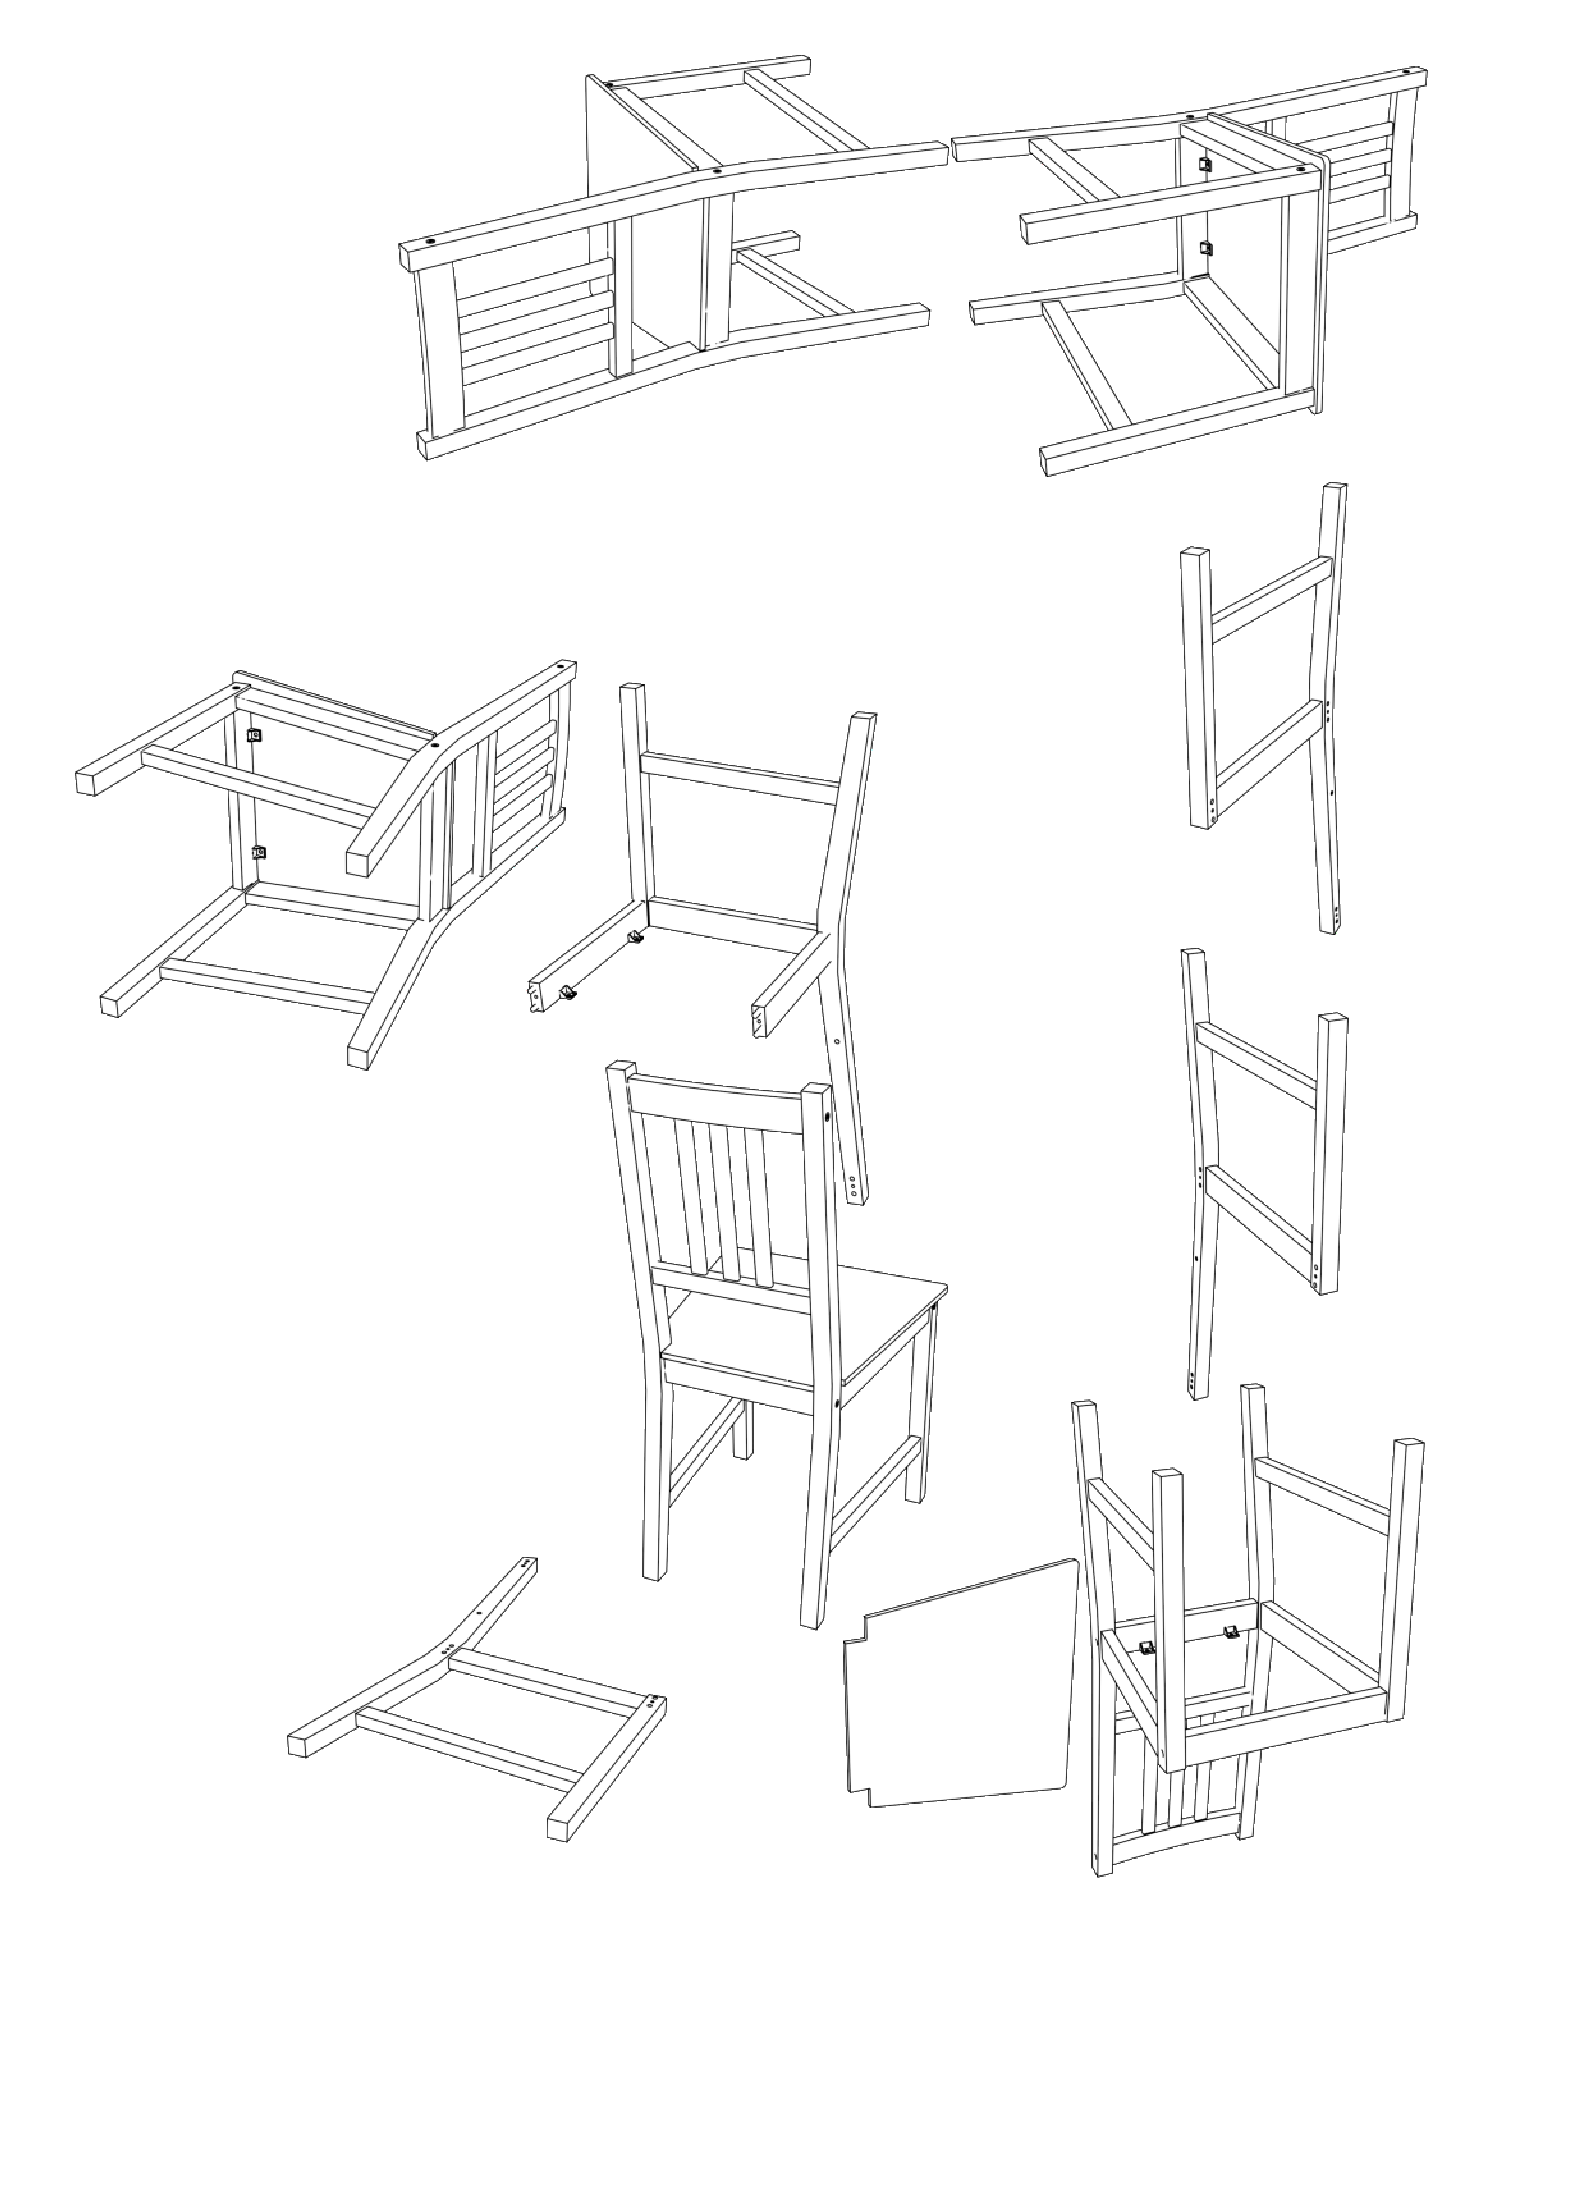

In [2]:
%matplotlib inline
data_dir = '../data'
input_dir = os.path.join(data_dir, 'input')
img_dirs = sorted(glob.glob(os.path.join(input_dir, 'image', '*')))

# choose name of image (from 0~9)
image_index = 0

img = plt.imread(img_dirs[image_index])
plt.figure(figsize=(30, 40))
plt.imshow(img)
plt.axis('off')

#### 1-3) test data 생성
최초 1회 실행


In [3]:
# %matplotlib tk
%run -i main.py --mode=test_data --gpu=3

Using TensorFlow backend.
/data/guest/Evaluation/3/codes/function/pose/pose_net.py:5: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('agg')


Using gpu : 3

loaded imgs :  (10, 1700, 1200, 3)
 SAVE TEST NPY
saved imgs :  (10, 1700, 1200, 3)
execution time : 4.7


<Figure size 432x288 with 0 Axes>

### 2) 부품 이미지 위치 추정 및 부품 구분 (새로운 부품 / 중간산출물)

#### 2-1) 정량적 결과

부품을 New(기본부품), Mid(중간산출물)로 구분했을 때, iou > 0.5에 해당하는 경우를 정답으로 처리하여

각각 AP (average precision)을 측정한 후, 이를 평균내서 mAP (mean average precision) 산출

In [4]:
# Detection
%run -i main.py --mode=detection --detection_visualization=True --gpu=3

Using gpu : 3

----------------
Loading Weights
----------------
DETECTION MODEL : Loading weights from ./model/detection/3.hdf5
loaded imgs :  (10, 1700, 1200, 3)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
---------------
AP: 100.00% (Mid)
AP: 97.44% (New)
mAP: 98.72%
execution time : 7.9


#### 2-2) 정성적 결과
추정된 기본부품과 중간산출물을 영역을 각각 다른 색깔로 표시

/data/guest/anaconda3/envs/robot3.5.6_3/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


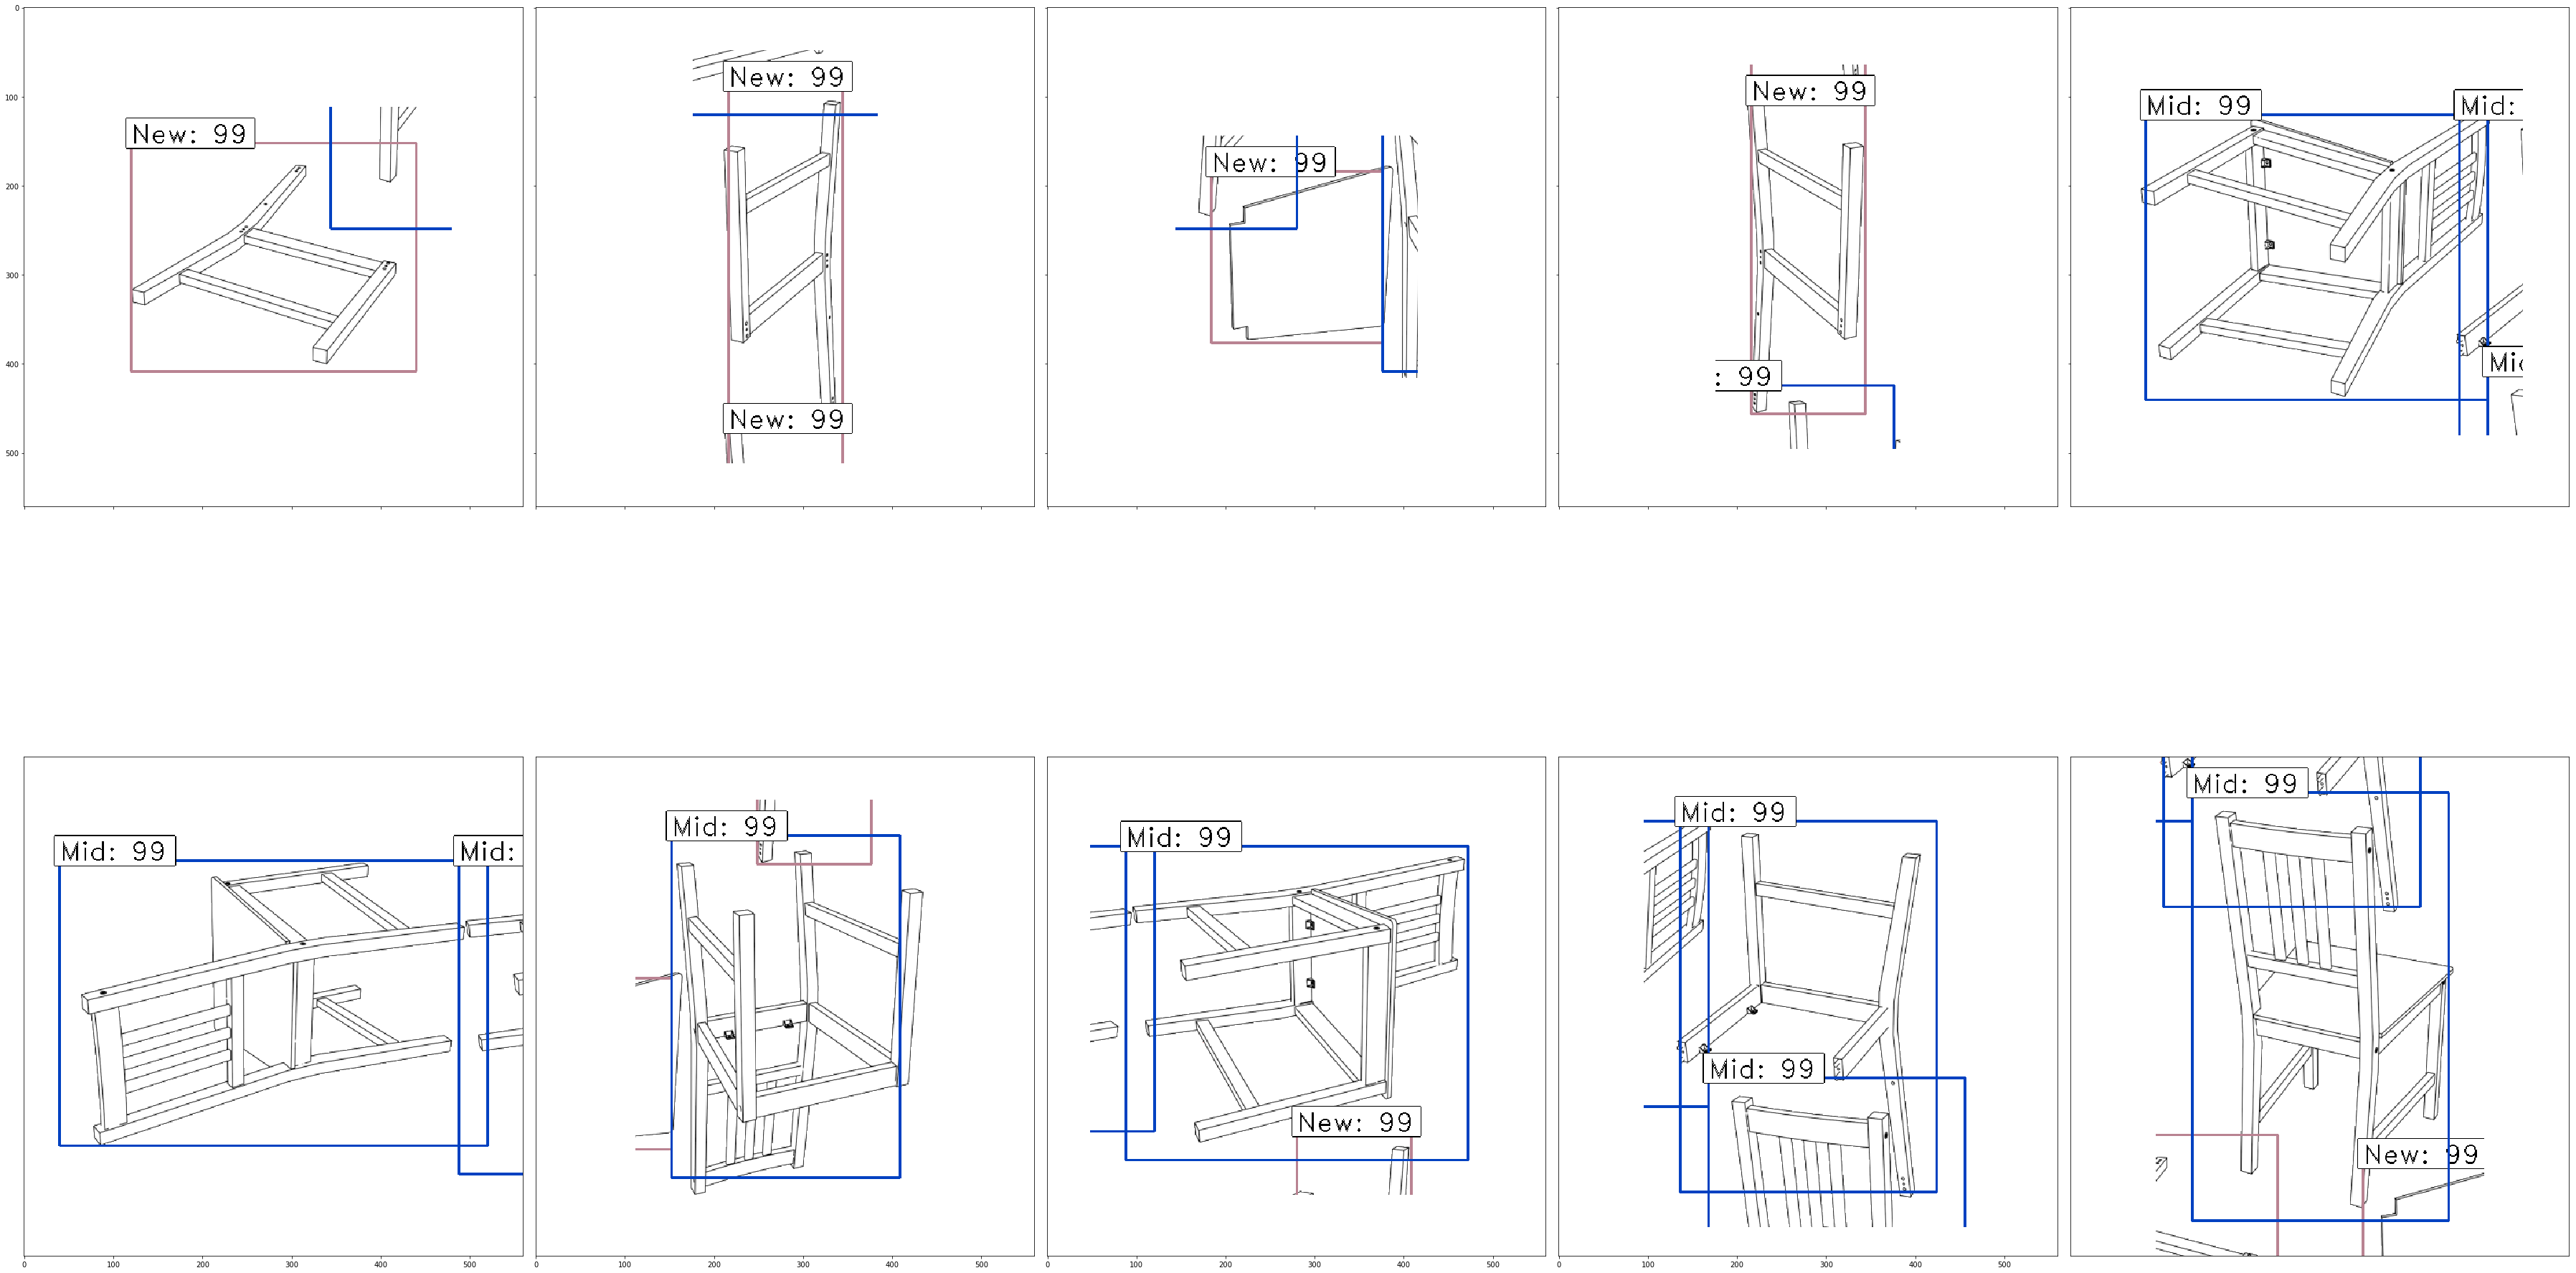

In [5]:
import matplotlib.pyplot as plt
import glob, os
import numpy as np
%matplotlib inline

# choose name of image (from 0~9)
image_index = 0

intermediate_dir = './intermediate_results'
detection_img_dir = sorted(glob.glob(os.path.join(intermediate_dir, 'detection', '*.png')))
detection_txt_dir = sorted(glob.glob(os.path.join(intermediate_dir, 'detection', '*.txt')))
img = plt.imread(detection_img_dir[image_index])
f = open(detection_txt_dir[image_index], 'r')
lines = f.readlines()
f.close()

fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', tight_layout=True, figsize=(50,50))

imgs=[]
hmax, wmax = (0, 0)
for i, line in enumerate(lines):
    line = line.split(' ')
    (x, y, x2, y2) = line[2:]
    y2 = y2[:-1]
    x = max(int(x)-40, 0)
    y = max(int(y)-40, 0)
    x2 = min(int(x2)+40, img.shape[1])
    y2 = min(int(y2)+40, img.shape[0])
    h, w = (y2-y, x2-x)
    hmax = max(hmax, h)
    wmax = max(wmax, w)
    imgs.append(img[y:y2, x:x2])

    
    
for i in range(5):
    h, w, c = imgs[i].shape
    h_pad = (hmax-h)//2
    w_pad = (wmax-w)//2
    imgs[i] = np.pad(imgs[i], ((h_pad, h_pad),(w_pad, w_pad), (0,0)), 'constant', constant_values=1)
    h, w, c = imgs[i+5].shape
    h_pad = (hmax-h)//2
    w_pad = (wmax-w)//2
    imgs[i+5] = np.pad(imgs[i+5], ((h_pad, h_pad),(w_pad, w_pad), (0,0)), 'constant', constant_values=1)
    ax[0][i].imshow(imgs[i])
    ax[1][i].imshow(imgs[i+5])

plt.xticks([])
plt.yticks([])
plt.subplots_adjust(hspace=0.001, wspace=0.1)


### 3) 부품 이미지 - CAD 매칭 

#### 3-1) 정량적 결과
각 부품의 종류(10가지)를 하나의 class로 취급하여 구분함.

각 class에 대하여 detection 결과가 iou > 0.5 이고, retrieval 결과가 정확한 경우를 정답으로 취급. AP (average precsion)을 측정하여, 전체 AP에 대한 평균으로 mAP (mean average precision)을 산출.

In [6]:
# for Retrieval
%run -i main.py --mode=retrieval --retrieval_visualization=True --gpu=3

Using gpu : 3

----------------
Loading Weights
----------------
DETECTION MODEL : Loading weights from ./model/detection/3.hdf5
RETRIEVAL MODEL : Loading saved model from ./model/retrieval/ckpt/Image/model.ckpt-9300
INFO:tensorflow:Restoring parameters from ./model/retrieval/ckpt/Image/model.ckpt-9300
RETRIEVAL MODEL : Loading saved model from ./model/retrieval/ckpt/View/model.ckpt-1800
INFO:tensorflow:Restoring parameters from ./model/retrieval/ckpt/View/model.ckpt-1800
RETRIEVAL MODEL : Loading saved model from ./model/retrieval/ckpt/Trans/model.ckpt-36000
INFO:tensorflow:Restoring parameters from ./model/retrieval/ckpt/Trans/model.ckpt-36000
loaded imgs :  (10, 1700, 1200, 3)
---------------
AP: 100.00% (Mid)
AP: 97.44% (New)
mAP: 98.72%
---------------
AP: 100.00% (part1)
AP: 66.67% (part3)
AP: 100.00% (part4)
AP: 100.00% (part5)
AP: 100.00% (part6)
AP: 93.33% (step2)
AP: 93.33% (step3)
AP: 88.89% (step4)
AP: 100.00% (step5)
AP: 100.00% (step7)
mAP: 94.22%
execution time : 27.0


<Figure size 432x288 with 0 Axes>

#### 3-2) 정성적 결과
좌 : detection 결과, 우 : retrieval 결과 (추정된 부품에 해당하는 rendering 이미지 표시)

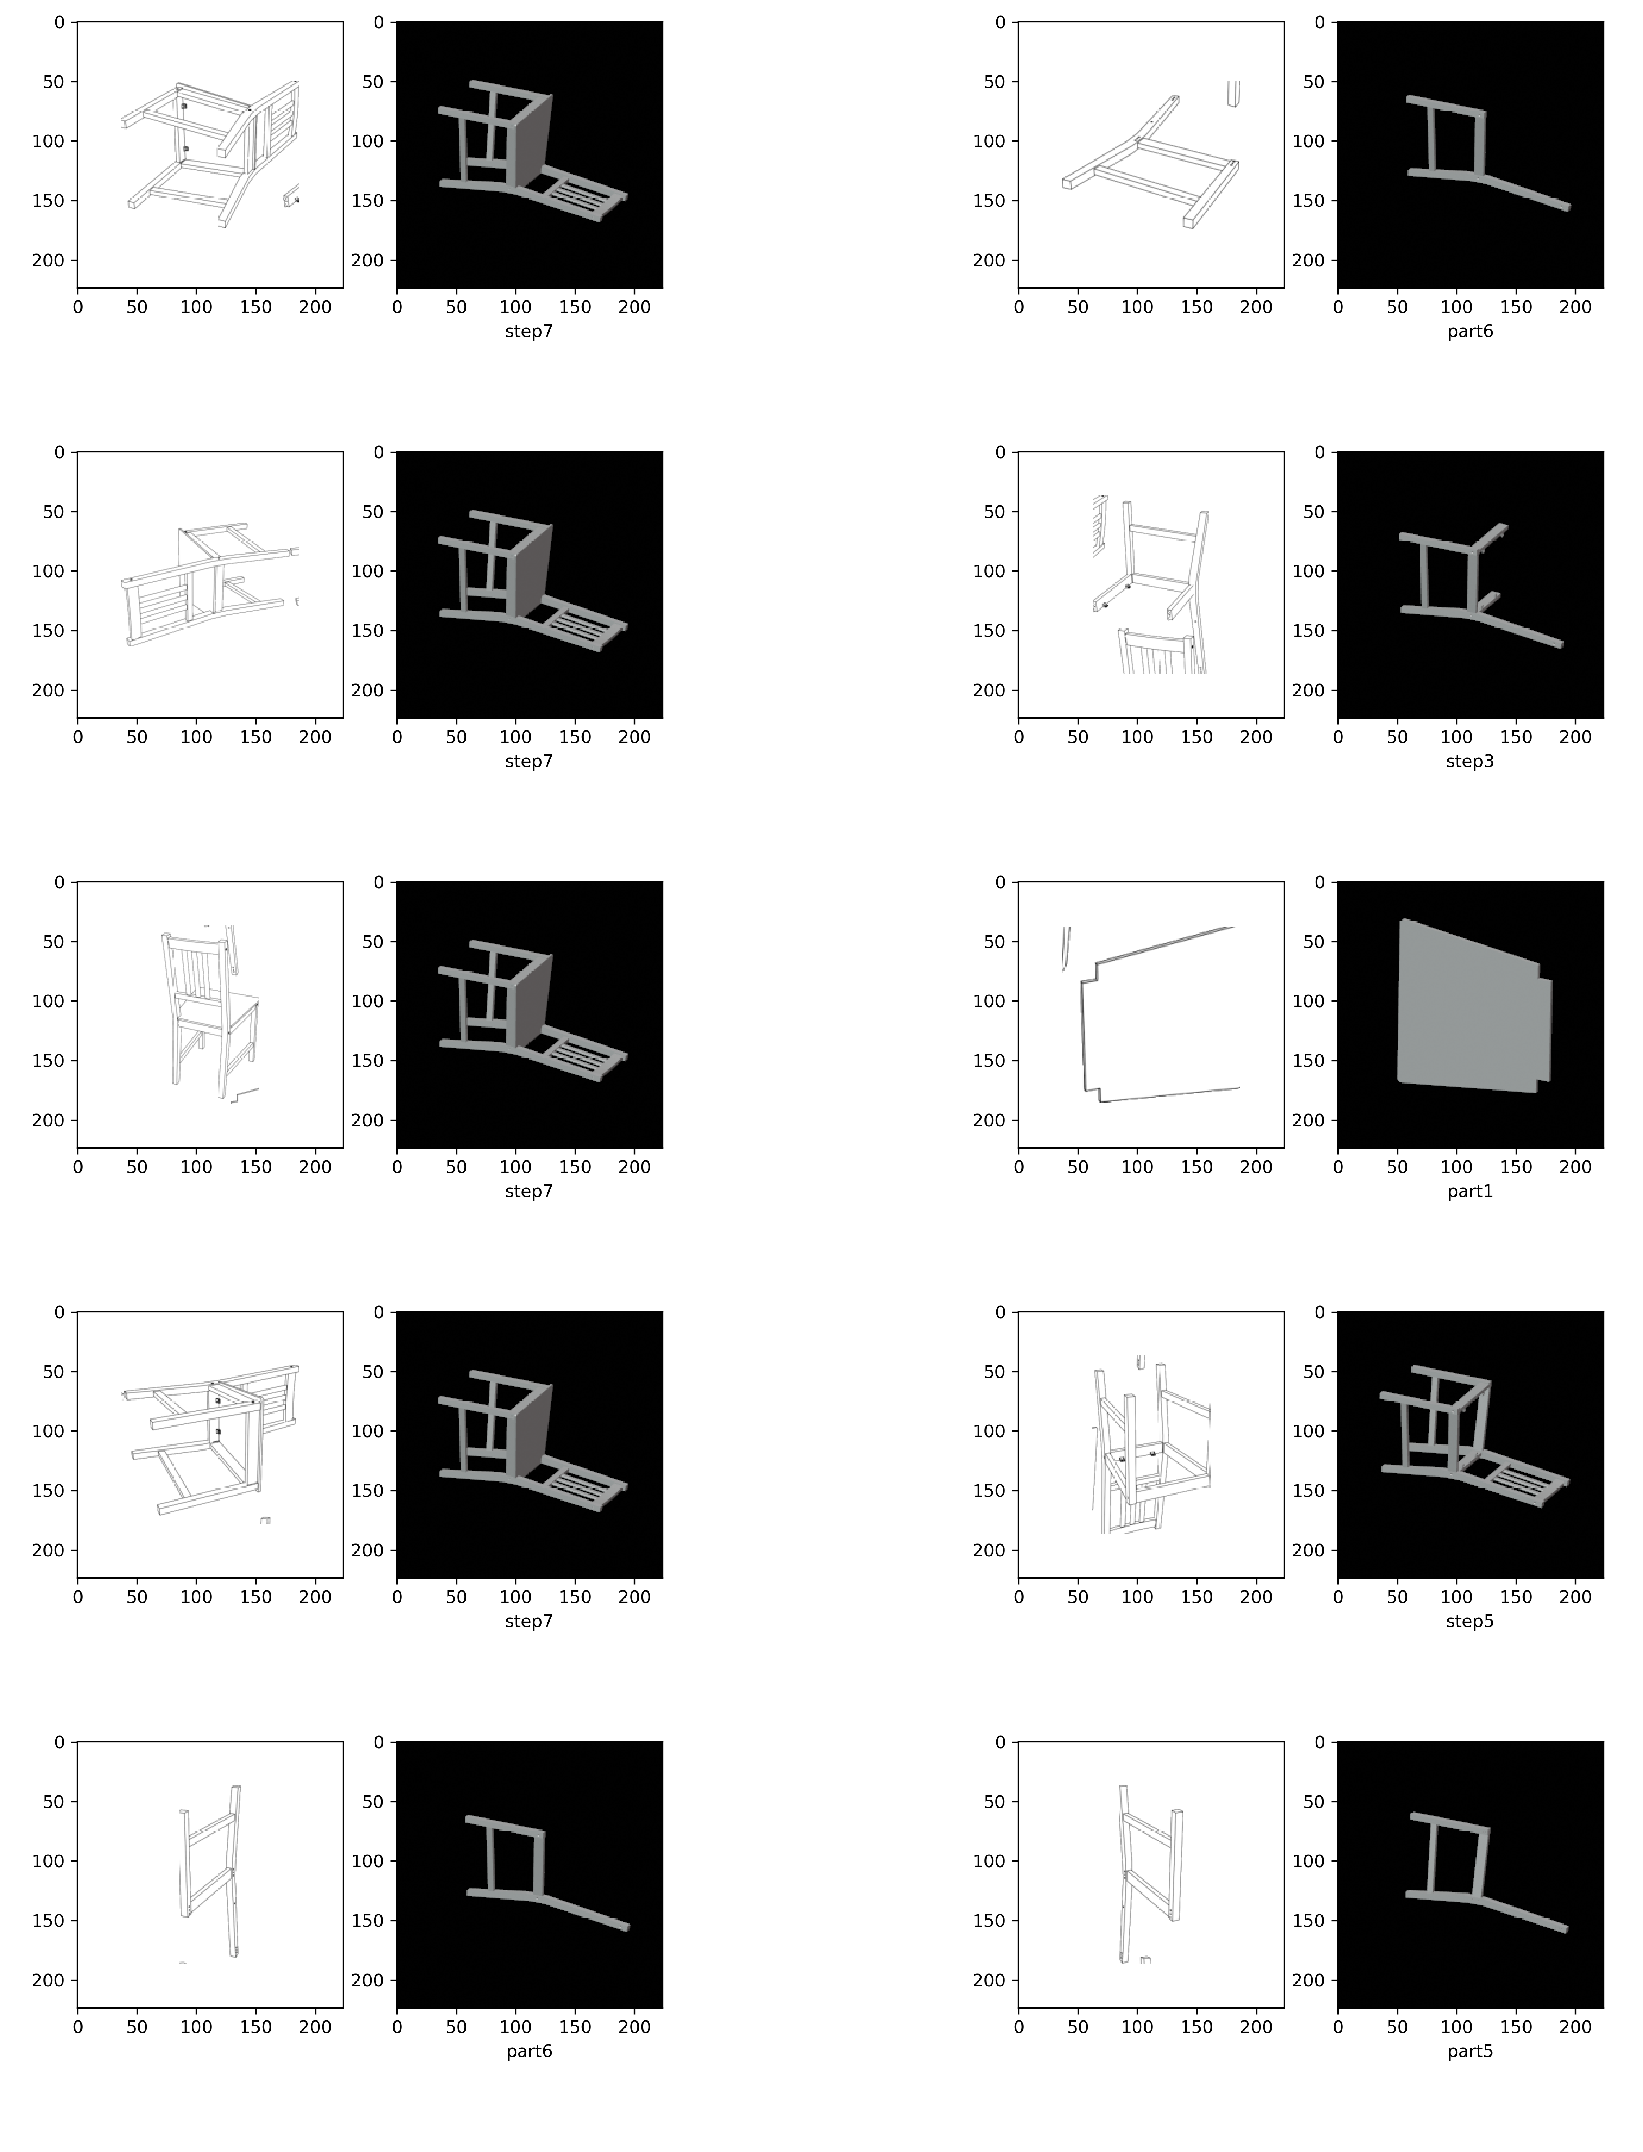

In [7]:
# retrieval 결과 불러오기 - 민우
import matplotlib.pyplot as plt
import glob, os
import numpy as np
%matplotlib inline

intermediate_results_path = './intermediate_results'
retrieval_results = sorted(glob.glob(os.path.join(intermediate_results_path,'retrieval','*.png')))
visualized_results = retrieval_results[:10]

rows = 5
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(30,30))
for i in range(rows):
    for j in range(cols):
        img_idx = 2*i+j
        img = plt.imread(visualized_results[img_idx])[250:1200,120:1700,:]
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
        plt.imshow(img)
fig.tight_layout()
plt.show()

### 4) 매칭 된 CAD 의 자세 추정

#### 4-1) 정량적 결과
각 부품의 종류(10가지), 자세의 종류(48가지)의 조합을 하나의 class로 취급하여 구분함 (총 10 x 48 = 480가지). 각각 이름은 [부품 이름]-[자세 이름]으로 표시.

각 class에 대하여 detection 결과가 iou > 0.5 이고, retrieval 결과가 정확하며, pose 결과가 정확한 경우를 정답으로 취급. AP (average precsion)을 측정함. 전체 AP에 대한 평균으로 mAP (mean average precision)을 산출.

In [8]:
# for Pose
%run -i main.py --mode=pose --pose_visualization=True --gpu=3

Using gpu : 3

----------------
Loading Weights
----------------
DETECTION MODEL : Loading weights from ./model/detection/3.hdf5
RETRIEVAL MODEL : Loading saved model from ./model/retrieval/ckpt/Image/model.ckpt-9300
INFO:tensorflow:Restoring parameters from ./model/retrieval/ckpt/Image/model.ckpt-9300
RETRIEVAL MODEL : Loading saved model from ./model/retrieval/ckpt/View/model.ckpt-1800
INFO:tensorflow:Restoring parameters from ./model/retrieval/ckpt/View/model.ckpt-1800
RETRIEVAL MODEL : Loading saved model from ./model/retrieval/ckpt/Trans/model.ckpt-36000
INFO:tensorflow:Restoring parameters from ./model/retrieval/ckpt/Trans/model.ckpt-36000
POSE MODEL : Loading weights from ./model/pose/model_weights-102
INFO:tensorflow:Restoring parameters from ./model/pose/model_weights-102
loaded imgs :  (10, 1700, 1200, 3)
---------------
AP: 100.00% (Mid)
AP: 97.44% (New)
mAP: 98.72%
---------------
AP: 100.00% (part1)
AP: 66.67% (part3)
AP: 100.00% (part4)
AP: 100.00% (part5)
AP: 100.00% (pa

/data/guest/Evaluation/3/codes/function/test/lib/Evaluator.py:130: RuntimeWarning: invalid value encountered in true_divide
  rec = acc_TP / npos


<Figure size 432x288 with 0 Axes>

#### 4-2) 정성적 결과
좌 : detection 결과, 우 : retrieval + pose 결과 (추정된 부품과 추정된 자세에 해당하는 rendering 이미지 표시)

/data/guest/anaconda3/envs/robot3.5.6_3/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


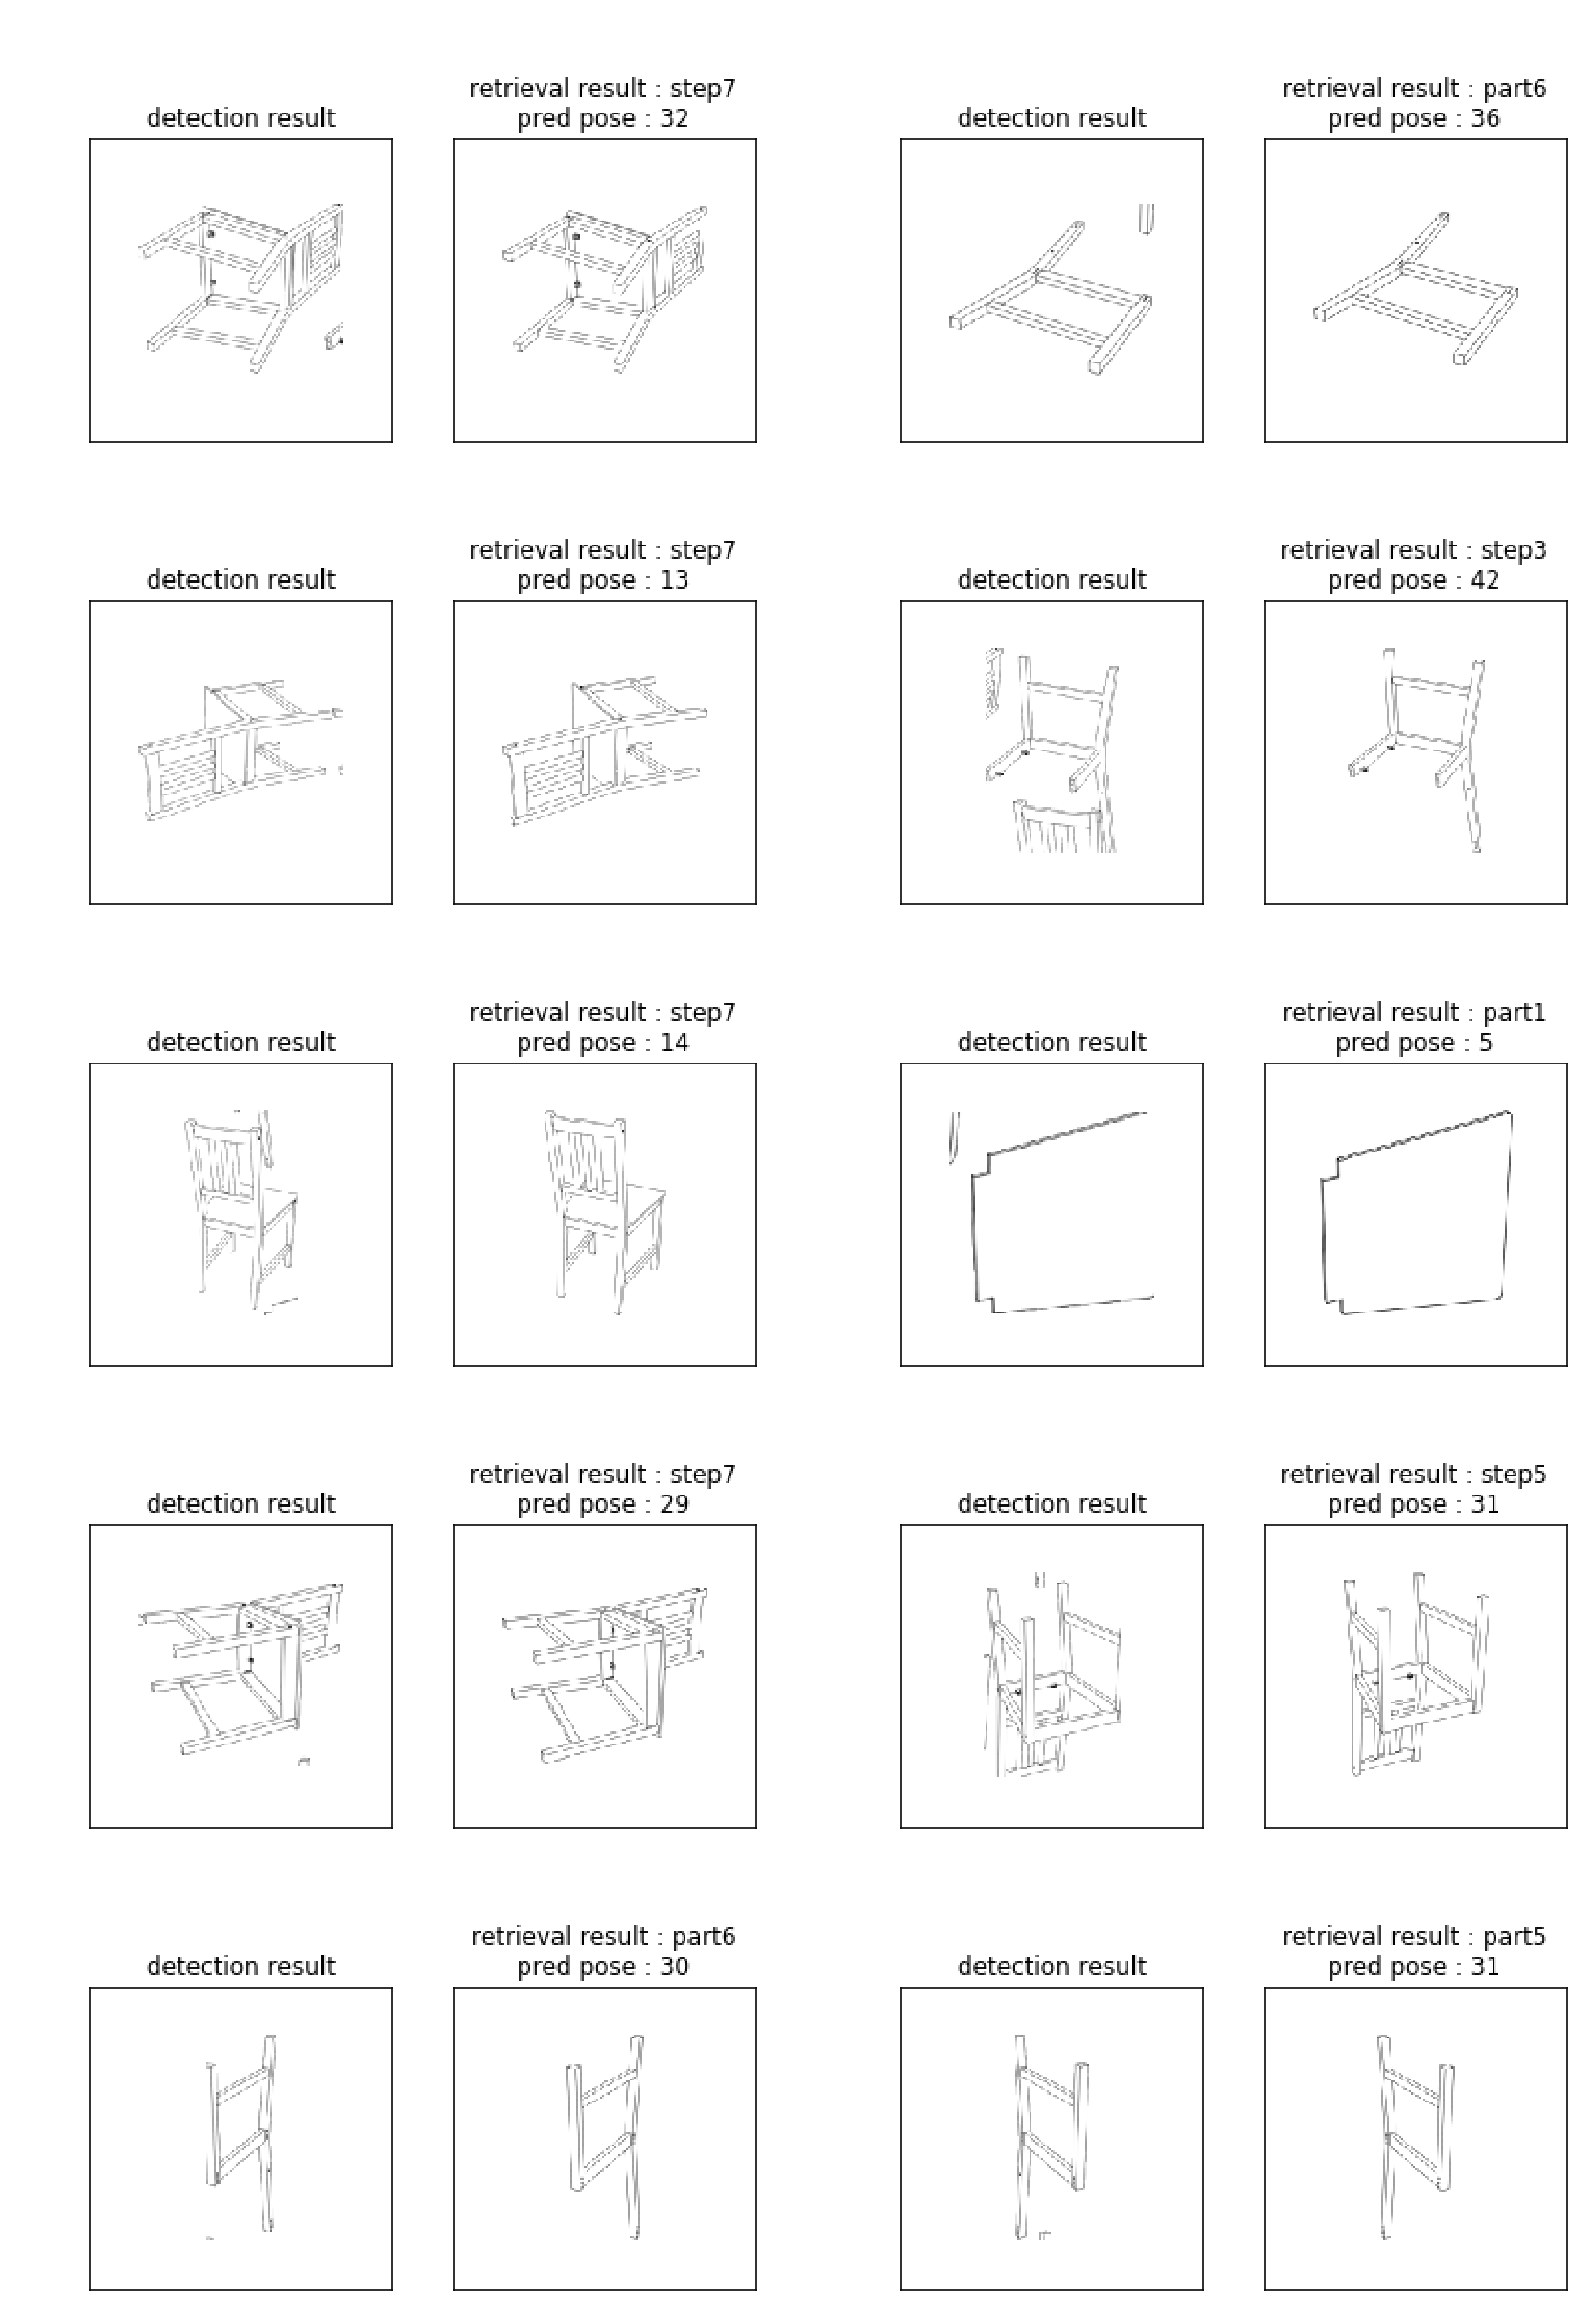

In [9]:
# pose visualization
import matplotlib.pyplot as plt
import glob, os
import numpy as np
%matplotlib inline

intermediate_dir = './intermediate_results'
pose_img_dir = sorted(glob.glob(os.path.join(intermediate_dir, 'pose', '*.png')))
imgs = [plt.imread(x) for x in pose_img_dir]

fig, ax = plt.subplots(5, 2, sharex='col', sharey='row', tight_layout=True)
fig.set_size_inches(40, 50)
for i in range(5):
    for j in range(2):
        img = imgs[2 * i + j][:-60, 20:-30]
        ax[i, j].imshow(img)
        ax[i, j].axis('off')

### 5) 최종 자세 / 위치 추정 실행 및 실행 시간 출력

#### 5-1) 정량적 결과

전체 과정을 수행. 결과 이미지를 저장하기 때문에, 시간 지연 요소가 있어 시험 목표 달성은 5-3) 단계에서 수행

detection, retrieval, pose 각 단계의 mAP 산출 방식은 2), 3), 4) 단계 참고

In [10]:
%run -i main.py --mode=test --output_visualization=True --gpu=3

Using gpu : 3

----------------
Loading Weights
----------------
DETECTION MODEL : Loading weights from ./model/detection/3.hdf5
RETRIEVAL MODEL : Loading saved model from ./model/retrieval/ckpt/Image/model.ckpt-9300
INFO:tensorflow:Restoring parameters from ./model/retrieval/ckpt/Image/model.ckpt-9300
RETRIEVAL MODEL : Loading saved model from ./model/retrieval/ckpt/View/model.ckpt-1800
INFO:tensorflow:Restoring parameters from ./model/retrieval/ckpt/View/model.ckpt-1800
RETRIEVAL MODEL : Loading saved model from ./model/retrieval/ckpt/Trans/model.ckpt-36000
INFO:tensorflow:Restoring parameters from ./model/retrieval/ckpt/Trans/model.ckpt-36000
POSE MODEL : Loading weights from ./model/pose/model_weights-102
INFO:tensorflow:Restoring parameters from ./model/pose/model_weights-102
loaded imgs :  (10, 1700, 1200, 3)
---------------
mAP: 94.22%
---------------
mAP: 94.74%
execution time : 10.1


/data/guest/Evaluation/3/codes/function/test/lib/Evaluator.py:130: RuntimeWarning: invalid value encountered in true_divide
  rec = acc_TP / npos


<Figure size 432x288 with 0 Axes>

#### 5-2) 정성적 결과

시험용 조립설명서 이미지에 대한 결과 표시. 

green : detection 결과의 iou > 0.5 이고, retrieval과 pose 추정의 결과가 정답일 경우

red : detection 결과의 iou > 0.5 이지만, retrieval 혹은 pose 추정의 결과가 오답일 경우

부품은 있는데 표시되지 않은 경우 : detection에서 부품을 찾지 못한 경우

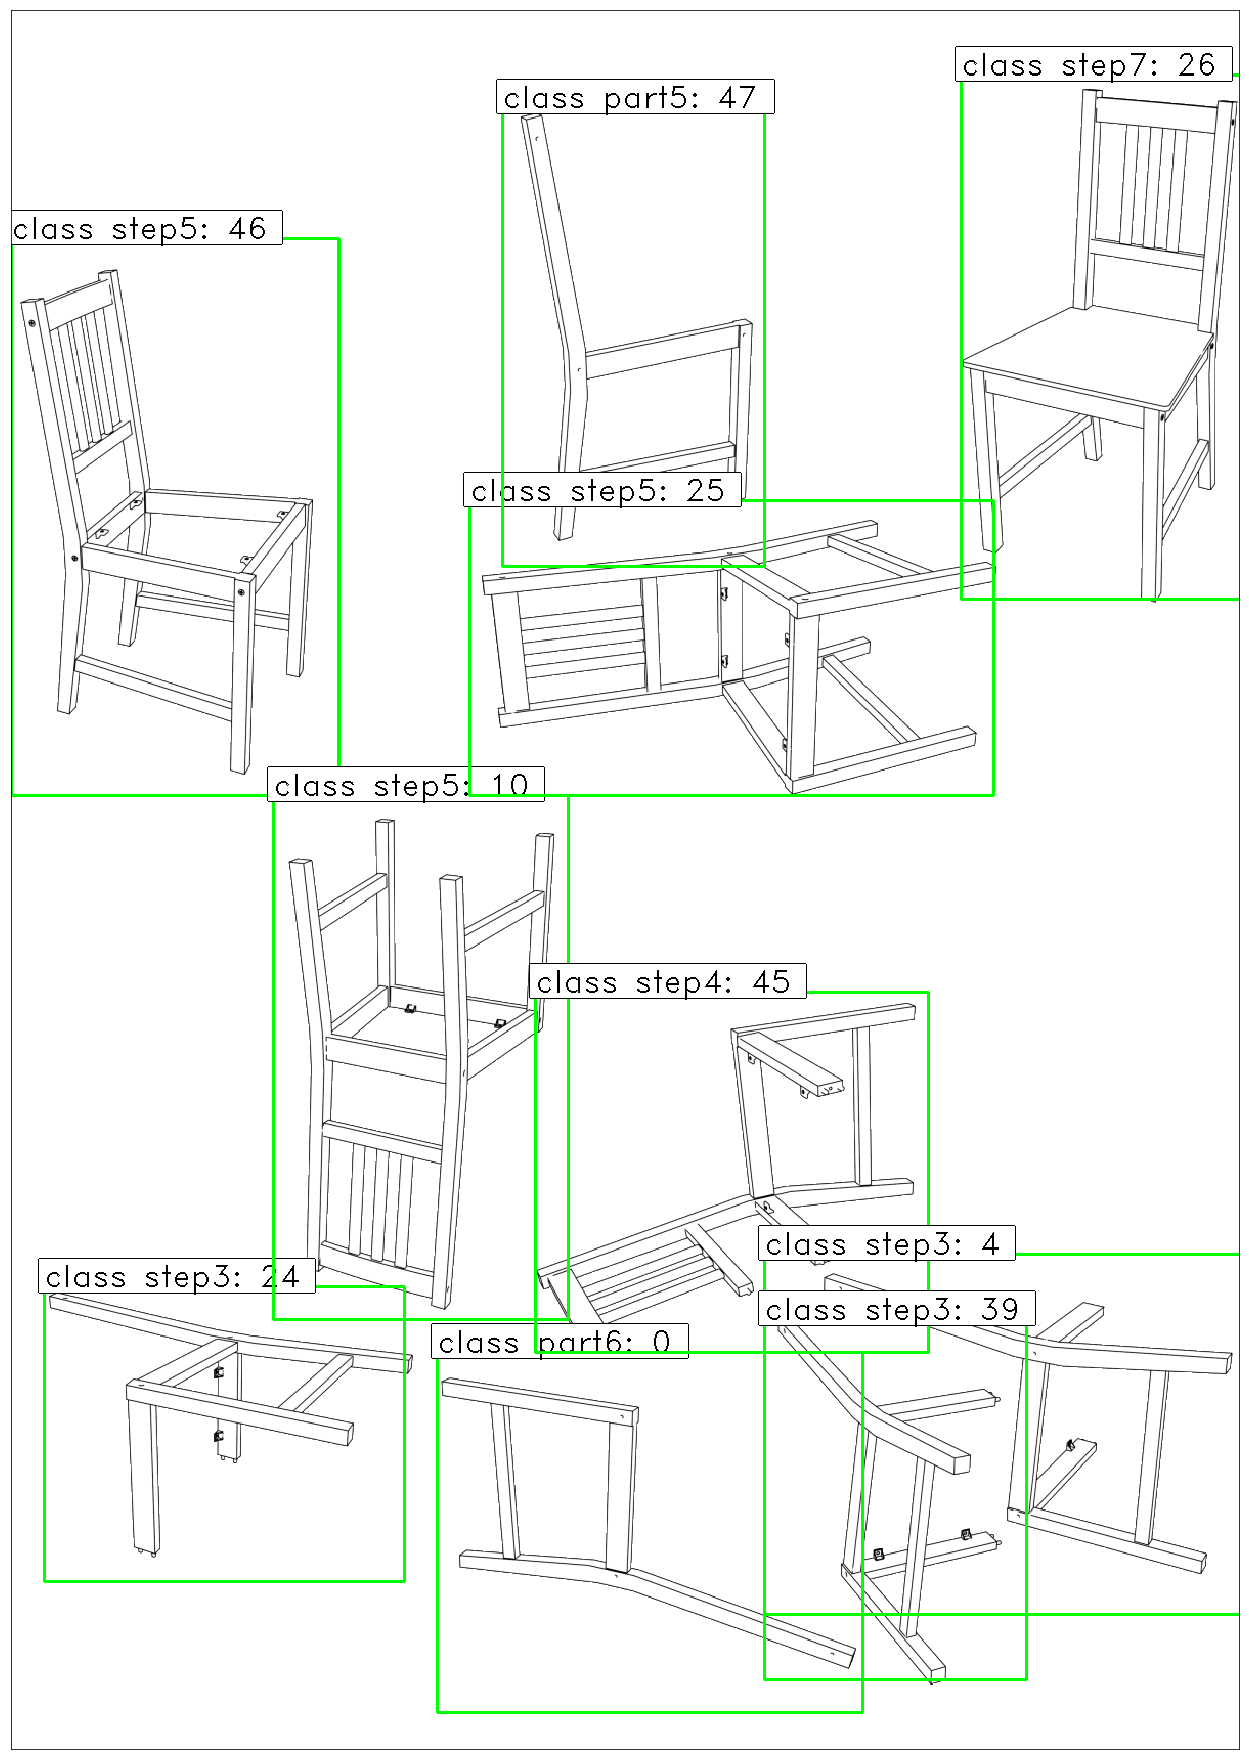

In [11]:
# test visualization
%matplotlib inline

# choose name of image (from 0~9)
image_index = 4

img = plt.imread('./output/' + str(image_index).zfill(5) + '.png')
plt.figure(figsize=(24, 32))
plt.xticks([])
plt.yticks([])
plt.imshow(img)

#### 5-3) 시험 수행

전체 과정에 대한 수행 시간을 측정함

- 코드 전체의 수행 시간은 Wall time 옆에 표시됨

- 시험용 조립설명서 10장에 대하여 한 번에 수행하기 때문에, 전체 수행 시간을 1/10하여 각 장당 수행 시간을 도출



In [2]:
%%time
%run -i main.py --mode=test --gpu=3

Using TensorFlow backend.
/data/guest/Evaluation/3/codes/function/pose/pose_net.py:5: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('agg')


Using gpu : 3

----------------
Loading Weights
----------------
DETECTION MODEL : Loading weights from ./model/detection/3.hdf5
RETRIEVAL MODEL : Loading saved model from ./model/retrieval/ckpt/Image/model.ckpt-9300
INFO:tensorflow:Restoring parameters from ./model/retrieval/ckpt/Image/model.ckpt-9300
RETRIEVAL MODEL : Loading saved model from ./model/retrieval/ckpt/View/model.ckpt-1800
INFO:tensorflow:Restoring parameters from ./model/retrieval/ckpt/View/model.ckpt-1800
RETRIEVAL MODEL : Loading saved model from ./model/retrieval/ckpt/Trans/model.ckpt-36000
INFO:tensorflow:Restoring parameters from ./model/retrieval/ckpt/Trans/model.ckpt-36000
POSE MODEL : Loading weights from ./model/pose/model_weights-102
INFO:tensorflow:Restoring parameters from ./model/pose/model_weights-102
loaded imgs :  (10, 1700, 1200, 3)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
---------------
---------------
mAP: 94.74%
execution time : 19.8
CPU times: user 21.2 s, sys: 2.72

/data/guest/Evaluation/3/codes/function/test/lib/Evaluator.py:130: RuntimeWarning: invalid value encountered in true_divide
  rec = acc_TP / npos
